In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

! mkdir data

! unzip /content/predict-energy-behavior-of-prosumers.zip -d data

KeyboardInterrupt: 

In [ ]:
!pip install --q neuralforecast==1.6.4

In [ ]:
!pip install -U polars==0.20.3 numpy==1.24.3

In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import holidays
import datetime
import warnings
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast

# Data preparation

Follows: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [ ]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [ ]:
def clean_interpolate_timeseries(df_data):

    # don't want this segment, most of the data is missing
    df_data = df_data.loc[
        ~(df_data[["county", "is_business", "product_type"]] == (12, 1, 3)).all(axis=1)
    ]

    chunks = []
    for (county, is_business, product_type), grp in df_data.groupby(
            ["county", "is_business", "product_type"]
    ):
        # interpolate missing values
        interpolated = (
            grp.sort_values(by="datetime")
            .set_index("datetime")
            .interpolate(method="time")
            .reset_index()
        )

        has_gaps = len(interpolated["datetime"].diff().value_counts()) != 1
        if has_gaps:
            # it is assumed that there will be no gaps between observations
            warnings.warn(
                f"{(is_business,product_type,county)=} has gaps in data (there are larger gaps than 1h in datetime column); skipping this series."
            )
            continue
        chunks.append(interpolated)
    df_train_interpolated = pd.concat(chunks).reset_index()

    return df_train_interpolated

In [ ]:
class FeaturesGenerator:
    def __init__(self):
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features


    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "hour", "dayofyear"
        )
        return df_features

    def generate_features(self, df_features):

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        return df_features

In [ ]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [ ]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"
root = "data"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [ ]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [ ]:
feat_gen = FeaturesGenerator()

In [ ]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = feat_gen.generate_features(df_train)
df_train = clean_interpolate_timeseries(to_pandas(df_train))

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [ ]:
# Remove old data
df_train = df_train[df_train["datetime"] >= pd.to_datetime("2022-11-03 00:00:00")]
df_train = df_train[df_train["datetime"] <= pd.to_datetime("2023-05-24 23:00:00")]

In [ ]:
df_train.shape

(302064, 34)

In [ ]:
df_train.columns

Index(['index', 'datetime', 'county', 'is_business', 'product_type',
       'production', 'consumption', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'eic_count', 'installed_capacity',
       'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'day', 'weekday', 'month', 'year',
       'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)',
       'is_country_holiday'],
      dtype='object')

In [ ]:
df_train.isna().sum()

index                                0
datetime                             0
county                               0
is_business                          0
product_type                         0
production                           0
consumption                          0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
eic_count                            0
installed_capacity                   0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
day                                  0
weekday                  

In [ ]:
static_df = df_train[["segment","county", "is_business", "product_type"]]
static_df = static_df.drop_duplicates()

# 2. Forecasting PRODUCTION

Follows: https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [ ]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST, VanillaTransformer, TFT, MLP, TimesNet, NHITS

In [ ]:
static = ["county", "is_business", "product_type"]
past_covariates = ["consumption","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards",
                    "sin(dayofyear)","cos(dayofyear)", "sin(hour)", "cos(hour)", "is_country_holiday"]

In [ ]:
output_size = 2*24 # 2 days ahead forecast
input_size = 7*24 # 7 days lookback window
models = [TimesNet(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          MLP(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          NHITS(h=output_size,
                input_size=input_size,
                stat_exog_list=static,
                hist_exog_list=past_covariates,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3),
          Informer(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          Autoformer(h=output_size,
                input_size=input_size,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3),
          PatchTST(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          VanillaTransformer(h=output_size,
                input_size=input_size,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3),
          TFT(h=output_size,
                input_size=input_size,
                stat_exog_list=static,
                hist_exog_list=past_covariates,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3)
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
n_time = len(df_train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time)

In [ ]:
nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.drop(columns=["county", "is_business", "product_type"]).rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None,
                               static_df=static_df.rename(columns={'segment':'unique_id'}))

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Y_hat_df.head()

unique_id                  ds              cutoff   TimesNet        MLP  \
0     0_0_1 2023-05-14 21:00:00 2023-05-14 20:00:00   3.698364  13.035761   
1     0_0_1 2023-05-14 22:00:00 2023-05-14 20:00:00  34.166504  33.642403   
2     0_0_1 2023-05-14 23:00:00 2023-05-14 20:00:00  53.417725  39.302818   
3     0_0_1 2023-05-15 00:00:00 2023-05-14 20:00:00  74.344055  48.575195   
4     0_0_1 2023-05-15 01:00:00 2023-05-14 20:00:00  66.850098  41.001545   

       NHITS   Informer  Autoformer   PatchTST  VanillaTransformer  ...  \
0  66.213318  69.029228  234.332306  77.294304           33.422283  ...   
1  56.869106   0.892639 -109.329758  39.853050           18.246012  ...   
2  42.904755   1.948578 -229.303650 -12.467346           21.367514  ...   
3  47.795368   2.008708 -180.008530  10.988342           21.718246  ...   
4  66.729515   2.008527 -151.376221   7.391685          111.957893  ...   

   total_precipitation  day  weekday  month  year  sin(dayofyear)  \
0                  0.0   14        7      5  2023        0.745438   
1                  0.0   14        7      5  2023        0.745438   
2                  0.0   14        7      5  2023        0.745438   
3                  0.0   15        1      5  2023        0.733885   
4                  0.0   15        1      5  2023        0.733885   

   cos(dayofyear)  sin(hour)  cos(hour)  is_country_holiday  
0       -0.666575  -0.707107   0.707107               False  
1       -0.666575  -0.500000   0.866025               False  
2       -0.666575  -0.258819   0.965926               False  
3       -0.679273   0.000000   1.000000               False  
4       -0.679273   0.258819   0.965926               False  

[5 rows x 40 columns]

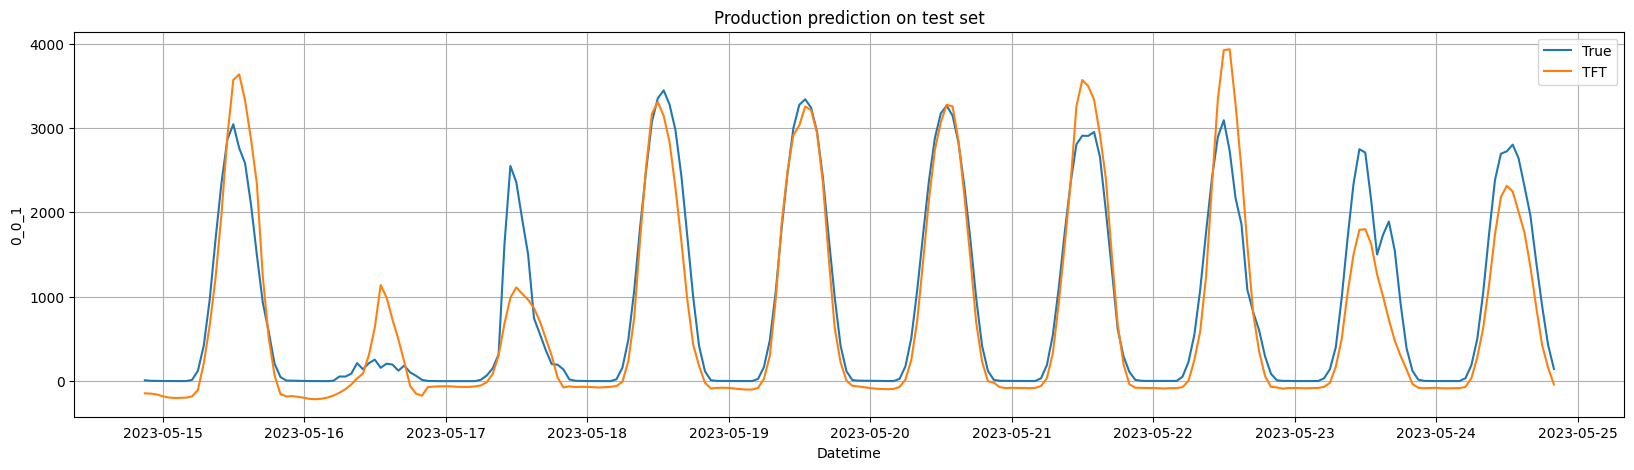

In [ ]:
# Visualize forecasts on one segment
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::output_size]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Production prediction on test set')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
#plt.plot(Y_plot['ds'], Y_plot['TimesNet'], label='TimesNet')
##plt.plot(Y_plot['ds'], Y_plot['MLP'], label='MLP')
#plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
#plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
#plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
##plt.plot(Y_plot['ds'], Y_plot['VanillaTransformer'], label='VanillaTransformer')
plt.plot(Y_plot['ds'], Y_plot['TFT'], label='TFT')
#plt.plot(Y_plot['ds'], Y_plot['NHITS'], label='NHITS')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('production_preds_example_b1.png')
plt.show()

In [ ]:
# compare MAE
from neuralforecast.losses.numpy import mae
mae_informer = mae(Y_hat_df['y'], Y_hat_df['Informer'])
mae_autoformer = mae(Y_hat_df['y'], Y_hat_df['Autoformer'])
mae_patchtst = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])
mae_vanilla = mae(Y_hat_df['y'], Y_hat_df['VanillaTransformer'])
mae_tft = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mae_mlp = mae(Y_hat_df['y'], Y_hat_df['MLP'])
mae_timesnet = mae(Y_hat_df['y'], Y_hat_df['TimesNet'])
mae_nhits = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

In [ ]:
print('Test period:')
Y_plot['ds'].min(), Y_plot['ds'].max()

Test period:


(Timestamp('2023-05-14 21:00:00'), Timestamp('2023-05-24 20:00:00'))

In [ ]:
mae_results = {
    'Model': ['VanillaTransformer', 'Informer', 'Autoformer', 'PatchTST', 'TFT', 'MLP', 'TimesNet', 'NHITS'],
    'MAE_production': [mae_vanilla, mae_informer, mae_autoformer, mae_patchtst, mae_tft, mae_mlp, mae_timesnet, mae_nhits]
}

results_df = pd.DataFrame(mae_results)

results_df.sort_values('MAE_production')

Model  MAE_production
4                 TFT      127.883957
3            PatchTST      132.781250
7               NHITS      139.629257
5                 MLP      150.676331
6            TimesNet      158.529678
2          Autoformer      283.986389
0  VanillaTransformer      325.273529
1            Informer      340.905670

In [ ]:
nf.save(path='./checkpoints/production_model/',
        model_index=None,
        overwrite=True,
        save_dataset=True)

In [ ]:
Y_hat_df.to_csv('production_predictions.csv')

# Forecasting consumption

In [ ]:
static = ["county", "is_business", "product_type"]
past_covariates = ["production","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards",
                    "sin(dayofyear)","cos(dayofyear)", "sin(hour)", "cos(hour)", "is_country_holiday"]

In [ ]:
output_size = 2*24 # 2 days ahead forecast
input_size = 7*24 # 7 days lookback window
models = [TimesNet(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          MLP(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          NHITS(h=output_size,
                input_size=input_size,
                stat_exog_list=static,
                hist_exog_list=past_covariates,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3),
          Informer(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          Autoformer(h=output_size,
                input_size=input_size,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3),
          PatchTST(h=output_size,
                input_size=input_size,
                val_check_steps=100,
                early_stop_patience_steps=3),
          VanillaTransformer(h=output_size,
                input_size=input_size,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3),
          TFT(h=output_size,
                input_size=input_size,
                stat_exog_list=static,
                hist_exog_list=past_covariates,
                futr_exog_list=future_covariates,
                val_check_steps=100,
                early_stop_patience_steps=3)
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf_cons = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df_cons = nf_cons.cross_validation(df=df_train.drop(columns=["county", "is_business", "product_type"]).rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None,
                               static_df=static_df.rename(columns={'segment':'unique_id'}))

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Y_hat_df_cons.head()

unique_id                  ds              cutoff    TimesNet         MLP  \
0     0_0_1 2023-05-14 21:00:00 2023-05-14 20:00:00  764.864990  645.477966   
1     0_0_1 2023-05-14 22:00:00 2023-05-14 20:00:00  742.901794  669.749390   
2     0_0_1 2023-05-14 23:00:00 2023-05-14 20:00:00  702.978760  605.483337   
3     0_0_1 2023-05-15 00:00:00 2023-05-14 20:00:00  638.681396  562.082886   
4     0_0_1 2023-05-15 01:00:00 2023-05-14 20:00:00  608.214722  512.738281   

        NHITS    Informer  Autoformer    PatchTST  VanillaTransformer  ...  \
0  642.918518  139.627014  555.657715  660.740906           94.486877  ...   
1  658.660461  136.946060  590.850586  679.299011           94.511650  ...   
2  622.269775  138.311600  617.035950  638.057251           94.511650  ...   
3  578.305725  138.269958  631.698547  593.133240           94.511650  ...   
4  564.094482  138.522614  636.608521  556.066223           94.511650  ...   

   total_precipitation  day  weekday  month  year  sin(dayofyear)  \
0                  0.0   14        7      5  2023        0.745438   
1                  0.0   14        7      5  2023        0.745438   
2                  0.0   14        7      5  2023        0.745438   
3                  0.0   15        1      5  2023        0.733885   
4                  0.0   15        1      5  2023        0.733885   

   cos(dayofyear)  sin(hour)  cos(hour)  is_country_holiday  
0       -0.666575  -0.707107   0.707107               False  
1       -0.666575  -0.500000   0.866025               False  
2       -0.666575  -0.258819   0.965926               False  
3       -0.679273   0.000000   1.000000               False  
4       -0.679273   0.258819   0.965926               False  

[5 rows x 40 columns]

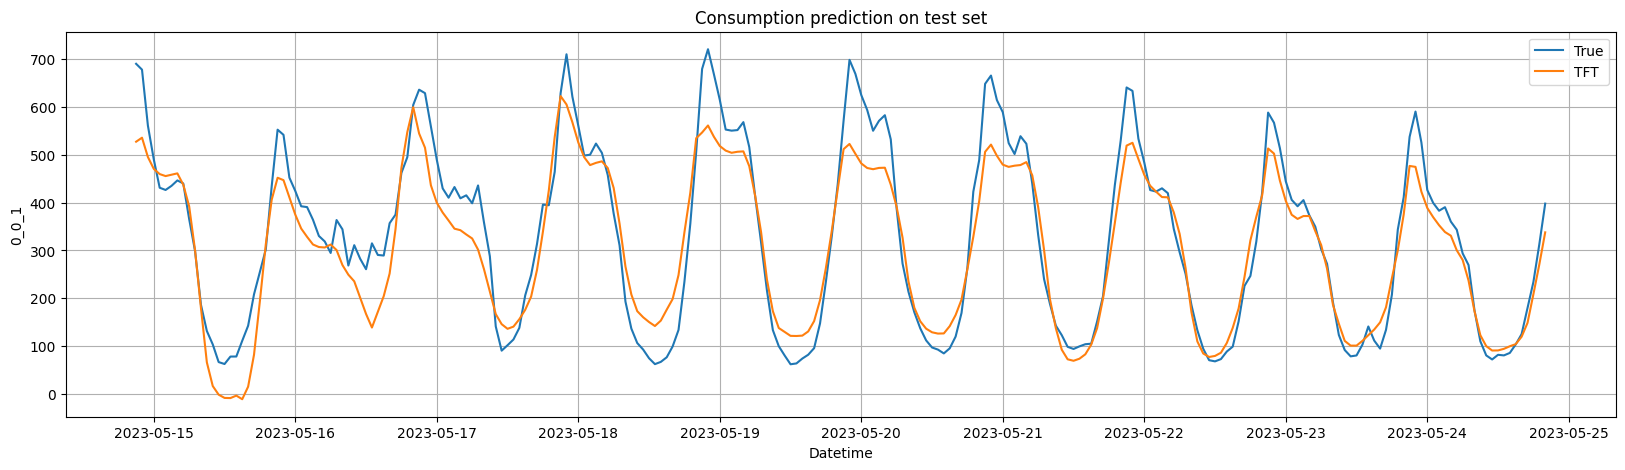

In [ ]:
# Visualize forecasts on one segment
segment='0_0_1'
Y_plot = Y_hat_df_cons[Y_hat_df_cons['unique_id']==segment]
cutoffs = Y_hat_df_cons['cutoff'].unique()[::output_size]
Y_plot = Y_plot[Y_hat_df_cons['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Consumption prediction on test set')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
##plt.plot(Y_plot['ds'], Y_plot['TimesNet'], label='TimesNet')
#plt.plot(Y_plot['ds'], Y_plot['MLP'], label='MLP')
#plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
#plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
#plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
#plt.plot(Y_plot['ds'], Y_plot['VanillaTransformer'], label='VanillaTransformer')
plt.plot(Y_plot['ds'], Y_plot['TFT'], label='TFT')
#plt.plot(Y_plot['ds'], Y_plot['NHITS'], label='NHITS')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('consumption_preds_example_b1.png')
plt.show()

In [ ]:
mae_informer = mae(Y_hat_df_cons['y'], Y_hat_df_cons['Informer'])
mae_autoformer = mae(Y_hat_df_cons['y'], Y_hat_df_cons['Autoformer'])
mae_patchtst = mae(Y_hat_df_cons['y'], Y_hat_df_cons['PatchTST'])
mae_vanilla = mae(Y_hat_df_cons['y'], Y_hat_df_cons['VanillaTransformer'])
mae_tft = mae(Y_hat_df_cons['y'], Y_hat_df_cons['TFT'])
mae_mlp = mae(Y_hat_df_cons['y'], Y_hat_df_cons['MLP'])
mae_timesnet = mae(Y_hat_df_cons['y'], Y_hat_df_cons['TimesNet'])
mae_nhits = mae(Y_hat_df_cons['y'], Y_hat_df_cons['NHITS'])

In [ ]:
print('Test period:')
Y_plot['ds'].min(), Y_plot['ds'].max()

Test period:


(Timestamp('2023-05-14 21:00:00'), Timestamp('2023-05-24 20:00:00'))

In [ ]:
mae_results = {
    'Model': ['VanillaTransformer', 'Informer', 'Autoformer', 'PatchTST', 'TFT', 'MLP', 'TimesNet', 'NHITS'],
    'MAE_consumption': [mae_vanilla, mae_informer, mae_autoformer, mae_patchtst, mae_tft, mae_mlp, mae_timesnet, mae_nhits]
}

results_df_cons = pd.DataFrame(mae_results)

results_df_cons.sort_values('MAE_consumption')

Model  MAE_consumption
4                 TFT        70.380402
3            PatchTST        73.551628
7               NHITS        75.606613
5                 MLP        76.259651
6            TimesNet        83.211372
2          Autoformer       114.670815
1            Informer       333.268036
0  VanillaTransformer       372.552917

In [ ]:
results_df_merged = results_df.merge(results_df_cons, on='Model')
results_df_merged['overall_MAE'] = (results_df_merged['MAE_production'] + results_df_merged['MAE_consumption']) / 2
results_df_merged.sort_values('overall_MAE')

Model  MAE_production  MAE_consumption  overall_MAE
4                 TFT      127.883957        70.380402    99.132179
3            PatchTST      132.781250        73.551628   103.166443
7               NHITS      139.629257        75.606613   107.617935
5                 MLP      150.676331        76.259651   113.467987
6            TimesNet      158.529678        83.211372   120.870529
2          Autoformer      283.986389       114.670815   199.328598
1            Informer      340.905670       333.268036   337.086853
0  VanillaTransformer      325.273529       372.552917   348.913208

In [ ]:
results_df_merged.to_csv('results_df_merged')

In [ ]:
nf_cons.save(path='./checkpoints/consumption_model/',
        model_index=None,
        overwrite=True,
        save_dataset=True)

# Ensamble

In [ ]:
Y_hat_df['best_mean'] = Y_hat_df[['TFT', 'PatchTST', 'NHITS']].mean(axis=1)

In [ ]:
mae_best_prod = mae(Y_hat_df['y'], Y_hat_df['best_mean'])

In [ ]:
mae_best_prod

113.72343

In [ ]:
Y_hat_df_cons['best_mean'] = Y_hat_df_cons[['TFT', 'PatchTST', 'NHITS']].mean(axis=1)

In [ ]:
mae_best_cons = mae(Y_hat_df_cons['y'], Y_hat_df_cons['best_mean'])

In [ ]:
mae_best_cons

63.385525

In [ ]:
(mae_best_prod + mae_best_cons) / 2

88.55447387695312

In [ ]:
mae_ensamble = {
    'Model': ['TFT+PatchTST+NHITS'],
    'MAE_production': [mae_best_prod],
    'MAE_consumption': [mae_best_cons],
    'MAE_overall': [(mae_best_prod + mae_best_cons) / 2]
}

mae_ensamble_df = pd.DataFrame(mae_ensamble)

mae_ensamble_df

Model  MAE_production  MAE_consumption  MAE_overall
0  TFT+PatchTST+NHITS      113.723427        63.385525    88.554474

In [ ]:
nf.models

[TimesNet, MLP, NHITS, Informer, Autoformer, PatchTST, VanillaTransformer, TFT]

In [ ]:
nf_cons.models

[TimesNet, MLP, NHITS, Informer, Autoformer, PatchTST, VanillaTransformer, TFT]